<a href="https://colab.research.google.com/github/leonardoLavagna/Quantum-Machine-Learning/blob/main/Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Machine Learning Notebook 1

In this notebook we will introduce the fundamental concepts of *quantum computation* and practice with the first building block of any quantum computing algorithm: *quantum circuits*, with a particular focus on *single qubit gates*. We will not follow a *programmer-centric* approach and circumvent the relevant mathematics and physics. Indeed we believe that if it is true that learning programming lenguages like $C++$ does not require the knowledge of the mathematics and physics behind transistor technology, in the case of quantum computation some knowledge of quantum mechanics cannot be avoided. Indeed when writing a program for a quantum computer one need to work directly with concepts like "unitary operators", "states", "density matrixes", "superposition", etc... ignorance in this case is definitely not a bliss. 

Throughout this notebook we will use the library [Qiskit](https://qiskit.org/) which allows to emulate a quantum computer with a python-based lenguage. To work out the following examples one can either use a local python distribution (e.g. using a virtual environment with Anaconda) or use the resources provided by [IBM QuantumLab](https://quantum-computing.ibm.com/lab). Indeed at this time a general-purpose QPU (Quantum Processing Unit) does not exists, but prototipes and simulators are currently available.

## Set-Up

In [ ]:
# INSTALLATION OF THE REQUIRED LIBRARIES
# Comment/Uncomment the following command(s), if needed

#!pip install qiskit

In [90]:
# IMPORT "QUANTUM" LIBRARIES
"""
  # QuantumCircuit: provides basic circuits and gates
  # assemble: allows to assemble circuits and convert them into "quantum objects"
  # Aer: provides a variety of high performance simulator backends 
  # transpile: allows to compile the programs
  # visualization: contains functions that perform some visualizations 
  # quantum_info Statevector: allows to initialize state vectors
"""

from qiskit import QuantumCircuit, assemble, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector

In [91]:
# IMPORT "CLASSICAL" LIBRARIES

import numpy as np
import numpy.linalg as la
import math

In [92]:
# GLOBAL VARIABLES

# Backend 
sim = Aer.get_backend('aer_simulator') 
# Global number of qubits
N = 1

## Introduction 

We will extensively use the [Copenhagen interpretation](https://en.wikipedia.org/wiki/Copenhagen_interpretation) of the quantum mechanics which can be summarized as follows:


*   Any quantum system is associated to a [Hilbert space](https://en.wikipedia.org/wiki/Hilbert_space) $\mathbb{H}$ where each observable (i.e. any quantity that can be experimentally measured like the position, the linear momentum, etc...) is a [self adjoint operator](https://en.wikipedia.org/wiki/Self-adjoint_operator) on $\mathbb{H}$
*  The states of a quantum systems are described as vectors $v\in\mathbb{H}$, these vectors are called *kets* and written as $|v\rangle$, their dual are called *bra* and denoted as $\langle v|$. Usually the states are associated to *wave functions* $\psi=\psi(x,t)$ that are the normalized (as probability densities) solutions of the *Schrödinger equation* (for a particle of mass $m$ under a potential $V$): $2mi\hbar\partial_t \psi=-\hbar^2\partial_{xx}\psi+V\psi$.
* The quantity $|\psi|^2dx$ describes the probability that a particle is in the interval $(x,dx)$, that is every cynematic and dinamic variable<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) $\delta$ is *non-local* in nature and only their "moments", like the expected value $\langle \delta \rangle$ and the variance $\sigma_\delta=\langle \delta^2\rangle-\langle \delta\rangle^2$, can be known. Moreover if $\psi$ is written in terms of a orthonormal basis $\{|\phi_i\rangle\}$ of the Hilbert space $\mathbb{H}$, that is $|\psi\rangle=\sum_i\alpha_i|\phi_i\rangle$ with $\alpha_i \in \mathbb{C}$, then any measure of $|\psi\rangle$ will result in a single $|\phi_i\rangle$ with probability $|\alpha_i|^2$.
* Prior to any measurement every particle is in a superposition of *pure states* $|\phi_i\rangle$ of the form $|\psi\rangle=\sum_i\alpha_i|\phi_i\rangle$. It is unsound to ask the "behaviour" of a particle before a measurement. 
* Pure states are seen up to a phase shift, that is if $|v\rangle$ is a ket with norm 1 (unit ket) then $|v\rangle$ and $|w\rangle =e^{ik}|v\rangle$ are indistinguishable. In other words pure states can be identified with the $1-$dimensional orthogonal projectors in $\mathbb{H}$ of the form $\varrho_v=|v\rangle\langle v|$ with $\langle v | v\rangle =1$. In this sense if there is a lack of knowledge of the physical conditions of a system, its state can be represented as a statistical mixture of pure states, called *mixed state* $\varrho=\sum_i\lambda_i|\phi_i\rangle\langle\phi_i|$ where the weights satisfy $\lambda_i\geq 0$, and $\sum_i\lambda_i=1$, that is $\varrho$ is a positive definite matrix with $Tr(\varrho)=1$ called *density matrix*.
* [Tensor products](https://en.wikipedia.org/wiki/Tensor_product) are used the extend the properties of the quantum system related to a single isolated particle to complex quantum systems with many particles.

We believe this is the most practical interpretation, which also is experimentally sustained by the confirmation of the famous [Bell inequalities](https://en.wikipedia.org/wiki/Bell%27s_theorem). This interpretation has dramatic consequences for quantum computations. For example every computation must satisfy a "unitary evolution" since, by the Schrödinger equation, the time evolution of an isolated quantum system is described by a one-parameter group of unitary operators<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) $\{U_t\}_{t\in \mathbb{R}}$ such that $$U_t:=\sum_{\lambda\in \sigma(H)} e^{-i\frac{t}{\hbar}\lambda}P_h=e^{-i\frac{t}{\hbar}H}$$ where $H$ is the Hamiltonian operator of the system (i.e. its total energy), $\sigma(H)$ is its spectrum, and $P_h$ is the *spectral measure* of $H$ (i.e. the collection of orthogonal projectors $P_h$ w.r.t $h$). This "unitary evolution" is a strong constraint on the possible operations that can be carried out, both from the engineering point of view and the software implementation point of view. This constraint can also give rise to some interesting computational advantages, but there is alwais a trade off... Unitary evolution bounds the computation capabilities, but in return it gives reversibility to each computation, quantum mechanical superposition allows to have in a single input multiple states, but then the measured output are probabilistic (which is completely general in a quantum computing setting), leveraging the non locality and the density matrix representation one can have "entagnlement approximations" and it is possible to perform exponentially more operations then a classical computer, but then the quantum system becomes instable, decoherence problems can arise, and will arise in a matter of milliseconds, and error correction codes will gobble the computational performance gain, etc... Having in mind the quantum mechanical fundamentals can help a lot in designing good algorithms by taking advantage of the quantum properties and at the same time mitigating their side effects. In this sense, and this is a crucial point, a quantum computer cannot be seen as a " conventional computer killer", instead it must be seen as a "conventional computer support worker". So, from a programmer point of view a quantum computer is a *co-processor*, a QPU, in the same fashion as CPUs and GPUs.

## Basic principles of quantum computing

In "classic" informatics the fundamental unit of information<a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3) is a *bit* which is usually represented with the set $\{0,1\}$. The fundamental unit of "quantum" information<a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4) is the *qubit*. Without diving too much into the quantum mechanical details, let's just say that a [qubit](https://it.wikipedia.org/wiki/Qubit) is a quantum system described by a bidimensional Hilbert space, often identified as $\mathbb{C}^2$. One of the main goals of any classical computation is to transform a sequence of bits into another sequences of bits, that is to compute particular functions $f:\{0,1\}^n\to \{0,1\}^n$. The [Church-Turing conjecture](https://en.wikipedia.org/wiki/Church%E2%80%93Turing_thesis) reads that any computable function $f$ can be computed by a Turing Machine, in essence by using circuits build from some universal gates (e.g. the *AND* gate, the *NOT* gate). In the "quantum" setting there is an analogue statement, but one must consider instead of sequences of bits, $n$ qubits in the Hilbert space $\mathbb{H}_n:=(\mathbb{C}^2)^{\otimes n}$, and instead of circuits build with gates one must consider circuits built with "quantum" gates. From a mathematical standpoint a *quantum gate* is any unitary operator acting on $\mathbb{H}_n$, but physically a quantum gate is a controlled time evolution of an isolated composite simple quantum mechanical system<a name="cite_ref-5"></a>[<sup>[5]</sup>](#cite_note-5). In this sense quantum gates are less intuitive then the corresponding classical gates. Truth be told, quantum computations carryied out by quantum gates have some properties that no classical circuit can display. Two obious such properties derive from the physical nature of the qubits: it is possible to leverage the *superposition principle*, and it is possible to leverage the *entanglement*. Some other, subtle, results are summarized below.


**Theorem (no cloning) .** *In a quantum computer it is impossible to clone the states. More precisely if $\mathbb{H}$ is the hilbert space representing any quantum system, and $|\eta\rangle \in \mathbb{H}$, then there is no unitary operator $U$ (called "quantum cloner") satisfying $U|\psi\rangle \otimes |\eta\rangle =|\psi\rangle \otimes |\psi\rangle $ for evry $|\psi \rangle \in \mathbb{H}$*.

This result has very strong implications in any algorithm implementation (e.g. it is impossible to copy the value of variable). From now on we will write tensor porducts in the following short form: $|\psi\rangle \otimes |\psi\rangle:= |\psi\psi\rangle$, likewise in more general settings.

*Proof .* By contraddiction. If $U$ is a quantum cloner then for evry choiche of the kets it holds $\langle\psi\eta| UU^\dagger |\phi\eta\rangle=\langle\psi | \phi\rangle\langle \eta | \eta\rangle=\langle \psi | \phi\rangle$ so $\langle \psi\psi|\phi\phi\rangle=\langle\psi|\phi\rangle\langle \psi | \phi\rangle=\langle\psi | \phi\rangle^2$ which is true only for coinciding orthogonal states.  $\Box$

**Theorem (reversibility) .** *All quantum computations are reversible*.

Also the proof of this result is simple, but the result itself tells something spectacular! Indeed in classical computing operations are almost always irreversible (e.g. the $AND$ gate is a function $\{0,1\}^2\to \{0,1\}$ so it cannot be invertible).

*Proof .* This is trivial since all quantum gates are unitary operations. $\Box$

**Theorem (universal gates) .** *There exists a finite set $X$ of ports such that any $n-$qubit gate, i.e. any element of $(\mathbb{C}^2)^{\otimes n}$ can be approximated to arbitrary accuracy by a finite composition of ports choosen from $X$*.

*Proof .* See the next Theorem about rotation gates. $\Box$

Notice that in the classical setting any function can be computed exactly using only a finite composition of ports choosen from $\{AND,OR,NOT\}$, whereas in the quantum computing setting we can only hope for good accuracy. There is more! Not only the computation will be prone to (controllable) errors due to the approximation stated in the previous theorem, but the results of a computation are themselves random! 

**Theorem (rotation gates) .** For any $1-$qubit gate $U$ there exists unitary operators $A,B;C$ with $ABC=Id$ such that for some $\alpha\in \mathbb{R}$ it holds $U=e^{i\alpha}A\sigma_xB\sigma_xC$ where $$\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}\ .$$

*Proof .* Since any single-qubit gate $U$ is a unitary operator, which can be represented with a matrix, it means that its columns are orthonormal wich means<a name="cite_ref-6"></a>[<sup>[6]</sup>](#cite_note-6) that there exists $\alpha,\beta, \gamma,\delta\in \mathbb{R}$ such that $$U=\begin{pmatrix}e^{i(\alpha-\beta/2-\delta/2)}\cos\frac{\gamma}{2}&-e^{i(\alpha-\beta/2+\delta/2)}\sin\frac{\gamma}{2} \\ e^{i(\alpha+\beta/2-\delta/2)}\sin\frac{\gamma}{2} & e^{i(\alpha+\beta/2-\delta/2)}\cos\frac{\gamma}{2}\end{pmatrix}$$ and the result follows by definition of matrix multiplication. $\Box$

## Simple Quantum Circuits

In *Qiskit* quantum circuits are fundamental logical unit to implement any algorithm and are provided by the module `QuantumCircuit`. In this module are implemented many important circuit gates, such has the *Hadamard Gate*. Remember that in this setting the typical workflow is divided into two parts: *Build* and *Run*. *Build* allows you to make different quantum circuits that represent the problem you are solving, and *Run* that allows you to run them on different backends. After the jobs have been run, the data is collected and postprocessed depending on the desired output.

In [93]:
# CREATE A CIRCUIT WITH n QUBITS
# Remark . When using a quantum simulator, which is a standard computer, set n<30
# otherwise the simulations will not be efficient or even halt.

qc = QuantumCircuit(N)

The extraction of outputs in a quantum circuit is done using the method `measure_all()`. Each measurement tells a specific qubit to give an output to a specific output bit. The command `qc.measure_all()` adds a measurement to each qubit in the circuit `qc`, and also adds some classical bits to write the output to.

In [94]:
# INITIALIZATION OF THE CIRCUIT WITH A MEASURE

qc.measure_all()

In [95]:
# PLOT OF THE CIRCUIT

qc.draw()

░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0

Qubits are always initialized to give the output 0. Since we don't do anything to our qubits in the circuit above, this is exactly the result we'll get when we measure them. The same initialization can be obtained with the module `Statevector`: first create the circuit, then initialize a state with the command `sv = Statevector(<data>)`. At this point the empty initialized circuit can be tested with the command method `sv.evolve(<circuit>)` and then the results can be visualized from the `sv.data` attribute.

In general, the output of any operation in a quantum computation framework is of probabilistic nature. We can see this by running the circuit many times and plotting the results in a histogram. We will find that the result is always $0$.

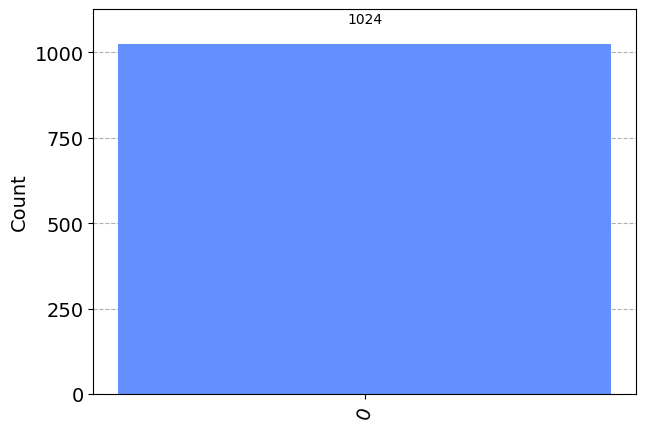

In [96]:
# MULTIPLE RUNS OF THE PREVIOUSLY INITIALIZED CIRCUIT

result = sim.run(qc).result()
counts = result.get_counts()
plot_histogram(counts)

Note that this result comes from a quantum simulator, which is a standard computer calculating what an ideal quantum computer would do. Simulations are only possible for small numbers of qubits. To run on a real device you simply need to replace `Aer.get_backend('aer_simulator')` with the backend object of the device you want to use. See [this tutorial](https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html) for further details.

**Remark .** Debugging QPU programs can be tough. Quite often the esiest way to understand the "mechanics" of a program is to slowly step through it, inspecting the visualizations at each step. That is why plots like the previous one are very useful.

### Encodings

As we've seen in the previous example we can define a simple circuit and initialize it. In classical computing the "initialization" has a well defined meaning: assign to the variable of interest a given specified value. For example if `N` is the variable which counts the number of qubits in a quantum circuit, then `N=1` is an initialization and with this value we've built our first circuit `qc = QuantumCircuit(N)`. The initialization of the quantum variable `qc` instead has been done using the method `measure_all()` which returns a measurement of the qubits. So in the classical framework "initialization" means "assignment", whereas in the quantum framework "initialization" means "measure" when the circuit is empty. The meaning of the initialization process in a quantum setting, though, can be fare more articulated then what we've just seen. Immagine the situation where you have a classical input that needs to be processed by a quantum circuit, what happens? We will need to "initialize" the input states of the quantum circuit with the values of the classical data... The techniques that allow to "translate" classical inputs into quantum states are called *encodings*. There are many different such techniques, let's just review the main ones:

**Basis encoding**: represent every classical data point as a basis vector, that is, if $X$ is the set of classical inputs we want to translate into the pysical states of a given quantum system we can just consider $x\in X\to |x\rangle \in \mathbb{H}$ where $x$ is represented as a binary string and where $\mathbb{H}$ is an hilbert space of dimension $|X|$ when $X$ is finite and . In particular one can map $\{0,1\}$ to $\{|0\rangle, |1\rangle\}$ where by convention<a name="cite_ref-7"></a>[<sup>[7]</sup>](#cite_note-7): $|0\rangle :={1\choose 0}$, and $|1\rangle:={0\choose 1}$. 

**Amplitude encoding**: represent evry classical data point as the amplitudes of a quantum state, that is, if $\mathbb{H}$ is an hilbert space of dimension $n$ with basis $\{\psi_1,\dots, \psi_n\}$ consider the map $x\in \mathbb{C}^n\to |\phi_x\rangle:=\sum_{i=1}^n x_i\psi_i\in \mathbb{H}$ where the various $x_i$ are the components of $x$.

Another important encoding is the *Angle encoding*, but it uses rotation gates, so we will discuss this technique later in the exercises. We have to say that many important quantum gates are associated to "change of basis" matrixes. For example given $$|+\rangle:= \frac{|0\rangle+|1\rangle}{\sqrt{2}} \ \ \ , \ \ \ |-\rangle:= \frac{|0\rangle-|1\rangle}{\sqrt{2}}$$ the *Hadamard gate* is the $1-$qubit gate that corresponds to the change of basis $\{|0\rangle, |1\rangle\}\to \{|+\rangle, |-\rangle\}$ and it is given in matrix form as $$ H:=\frac{1}{\sqrt{2}}\begin{pmatrix}1&1\\1&-1\end{pmatrix} \ .$$


As an example of encoding lets discuss the aplitude encoding, the other two other encodings (angle and basis) are left as exercises.

In [139]:
# AMPLITUDE ENCODING OF A CLASSICAL DATASET X

# Classical Dataset with length that must be a power of 2
X = ["a","b","c","d"]

# Step 1: binary transformation
X_binary = []
for item in X:
  item = bin(ord(item))
  X_binary.append(int(item[2:]))

print("Elements of X as binary strings")
print(X_binary)
# Step 2: encoding
n = math.log2(len(X_binary))
qc = QuantumCircuit(n)  
qc.initialize(X_binary / la.norm(X_binary)) 

# Visualization
print("Amplitude encoding of the binary strings")
qc.draw()

Elements of X as binary strings
[1100001, 1100010, 1100011, 1100100]
Basis encoding of the binary strings


┌──────────────────────────────────────────────┐
q_0: ┤0                                             ├
     │  Initialize(0.49999,0.49999,0.49999,0.50003) │
q_1: ┤1                                             ├
     └──────────────────────────────────────────────┘

When the classical dataset is numeric, the previous steps can be merged as follows.

In [98]:
# Classical dataset
X = [0,1,3,2]
X = np.array(X, dtype=float)

# Encoding
n = int(math.log2(len(X)))
qc = QuantumCircuit(n)
qc.prepare_state(X / la.norm(X))
qc.draw()

┌───────────────────────────────────────────────┐
q_0: ┤0                                              ├
     │  State Preparation(0,0.26726,0.80178,0.53452) │
q_1: ┤1                                              ├
     └───────────────────────────────────────────────┘

Another interesting and useful visualization is given by the decomposition of the circuit into elementary gates. If one looks carefully at the previous visualizations, it is possible to see that the encoding process is treated as a single unitary operation, which is then plotted as a signle quantum gate. But we know from the universal gates theorem that every gate can be approximated 
with arbitrary accuracy by a combination of "elementary" gates. For example in the previous case one can decompose the initialized circuit with the encoded data as follows.

In [99]:
# CIRCUIT DECOMPOSITION INTO ELEMENTARY GATES

qc.decompose().decompose().decompose().decompose().draw()

┌────────────┐ ┌───┐┌─────────────┐┌───┐
q_0: ──┤ Ry(2.1588) ├─┤ X ├┤ Ry(0.98279) ├┤ X ├
     ┌─┴────────────┴┐└─┬─┘└─────────────┘└─┬─┘
q_1: ┤ R(2.6005,π/2) ├──■───────────────────■──
     └───────────────┘

We can see that this encoding in the working example corresponds to the composition of rotation gates $R$ and not gates $X$.

**Remark .** In principle every algorithm implemented as a quantum circuit can be decomposed into elementary gates and a "natural" sense of the "depth" of a circuit arises. We will dive into the details of most of the elementary gates exemplified above, for the moment lets just apreciate the fact that the more an algorithm is "complex", more elementary gates are needed, and the depth of the circuit increases. Since every gate takes a fixed amount of time to be evaluated the depth of a circuit is related to the computational time complexity of algorithms. One can even recover the complexity classes like $P$ and $NP$ by taking into account the intrinsic error probabilities in the results provided by a quantum algorithm. See https://en.wikipedia.org/wiki/Quantum_complexity_theory for further details.

### The Bloch sphere

The [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere) is a useful tool to visualize encoded data and qubit manipulations. Recall that if we have a single qubit $|\psi\rangle$ we can write it in terms of the canonical base of $\mathbb{C}^2$, that is $|\psi\rangle = \alpha|0\rangle + \beta |1\rangle$ with $\alpha,\beta\in \mathbb{C}$. Since pure states are equivalent up to a phase shift we can write $|\psi\rangle = \alpha|0\rangle + e^{ik}\beta |1\rangle$ and this time $\alpha,\beta,k\in \mathbb{R}$. The normalization conditions on the qubit state imply $\sqrt{\alpha^2+\beta^2}=1$ so we can represent $\alpha$ and $\beta$ in terms of an angular variable $\theta$ as $$\alpha=\cos\frac{\theta}{2}\ \ \ , \ \ \ \beta=\sin\frac{\theta}{2}\ . $$ In this sense every qubit $|\psi\rangle$ can be decomposed as $$|\psi\rangle =\cos\frac{\theta}{2}|0\rangle +e^{ik}\sin\frac{\theta}{2}|1\rangle$$ with $\theta,k \in \mathbb{R}$. With this representation we can interpret $\theta,k$ as coordinates on the unit sphere (the normalization condition imply $r=1$) which is called the *Bloch sphere*. 

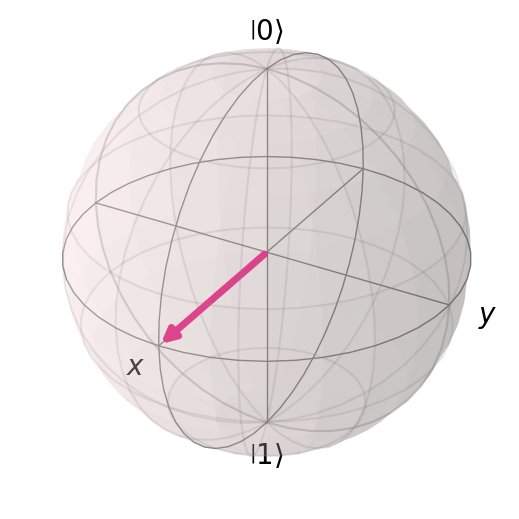

In [100]:
# EXAMPLE OF A VECTOR IN THE BLOCH SPHERE

coords = [1,math.pi/2,0] 
plot_bloch_vector(coords, coord_type='spherical')

The action of a gate on a qubit can then be visualized as an operation (usually a composition of rotations) on the Bloch sphere.

### Some Basic Single qubit Gates

After creating a quantum circuit with its registers, as we've done with the method `QuantumCircuit()`, we can add gates (“operations”) to manipulate the registers. 

**The NOT Gate .** The first and most simple quantum gate is the *quantum* $NOT$ which is the analogue of the $NOT$ gate for a classical circuit. In Qiskit the $NOT$ gate is obtained with the `x` method, as shown below. 

In [101]:
# CREATE THE CIRCUIT
# Remark . This step is of crucial importance and cannot be avoided.
# Indeed in a quantum setting after a measurement "the wave function collapses".

qc = QuantumCircuit(N)

In [102]:
# APPLY THE NOT GATE ON THE LAST qubit

qc.x(N-1)
qc.draw()

┌───┐
q: ┤ X ├
   └───┘

As you can see the qubit $q_7$ has been modified. We can extract the results as we've done before an then run the circuit multiple times.

In [103]:
# MEASURE THE CIRCUIT

qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

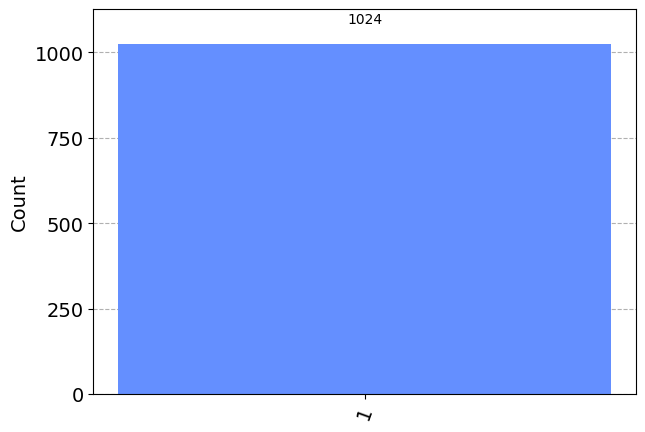

In [104]:
# MULTIPLE RUNS OF THE PREVIOUSLY INITIALIZED CIRCUIT

result = sim.run(qc).result()
counts = result.get_counts()
plot_histogram(counts)

Now our computer outputs the string 10000000. The bit we flipped, which comes from $q_7$, lives on the far left of the string. This is because Qiskit numbers the bits in a string from right to left. In particular we've changed the output form $0=\sum_{i=0}^7 0\cdot 2^i$ to $128=1\cdot 2^7+\sum_{i=0}^60\cdot 2^i=2^7$

As mentioned before, we can visualize the action of a gate on the Bloch sphere, in this case we have the following operation.

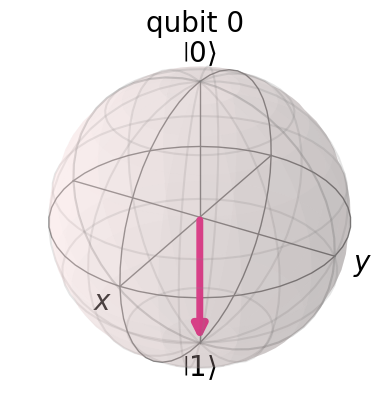

In [105]:
# ACTION OF THE NOT GATE ON THE BLOCH SPHERE

qc = QuantumCircuit(N)
qc.x(N-1)
state = Statevector(qc)
plot_bloch_multivector(state)

**The Hadamard H Gate .** When talking about encodings we've mentioned that many important encodings are associated to changes of basis in the hilbert space $(\mathbb{C}^2)^{\otimes n}$. Indeed many important gates are associated to rotations of the standard basis seen in the basis encodings. Recall that the *Hadamard Gate* $H$ is given in matrix form as $$ H:=\frac{1}{\sqrt{2}}\begin{pmatrix}1&1\\1&-1\end{pmatrix}$$ and it is a change of basis in $\mathbb{C}^2$ such that $|0\rangle \to |+\rangle $ and $|1\rangle \to |-\rangle$. We can decompose $H$ using a $\frac{\pi}{2}$ rotation $R_y(\frac{\pi}{2})$ in the $y$ axes and a $\pi$ rotation $R_x(\pi)$ in the $x$ axes<a name="cite_ref-8"></a>[<sup>[8]</sup>](#cite_note-8): $$H=\frac{1}{\sqrt{2}}\begin{pmatrix}1&1\\1&-1\end{pmatrix}=\frac{1}{\sqrt{2}}\begin{pmatrix}0&1\\1&0\end{pmatrix}\begin{pmatrix}1&-1\\1&1\end{pmatrix}=R_x(\pi)R_y(\frac{\pi}{2}) \ .$$ 
Since the Hadamard gate is simple and useful, Qiskit has a specific method for it which is `h`, but since not every possible gate is pre-defined on Qiskit (or in any other quantum computation software, recall the universal gates Theorem) it is important to be able to build gates from elementary rotations. The same is true for the $NOT$ gate: it is simple and useful, Qiskit has a specific method for it, but it is possible to build it from rotation gates (just use a rotation by $\pi$ on the desired axes, e.g. by using the Pauli gates we will discuss in a moment).

In [106]:
# CREATE THE CIRCUIT

qc = QuantumCircuit(N)

In [107]:
# APPLY THE H GATE TO THE FIRST qubit

qc.h(0)
qc.draw()

┌───┐
q: ┤ H ├
   └───┘

In [108]:
# MEASURE THE CIRCUIT

qc.measure_all()
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

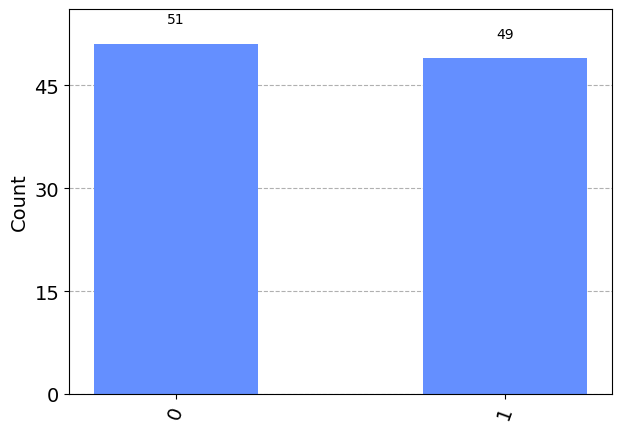

In [109]:
# MULTIPLE RUNS OF THE PREVIOUSLY INITIALIZED CIRCUIT

result = sim.run(qc,shots=100).result()
counts = result.get_counts()
plot_histogram(counts)

Try changing the `shots` keyword in the `sim.run` function and see how the estimated probabilities change. Here we can see a first example of a pure quantum phenomena. We can have superpositions of states, in particular if we apply the gate to $|0\rangle$ we have $H|0\rangle=\frac{1}{\sqrt{2}}{1\choose 1}$ and the probability of measuring $|0\rangle$ is $(\frac{1}{\sqrt{2}})^2=\frac{1}{2}$. Likewise the probability of measuring $1$ is $\frac{1}{2}$. In conclusion, applying the Hadamard Gate to a qubit that is in state $|0\rangle$ brings the qubit in a superposition state where the probability of measuring $0$ is equal to the probability of measuring $1$.

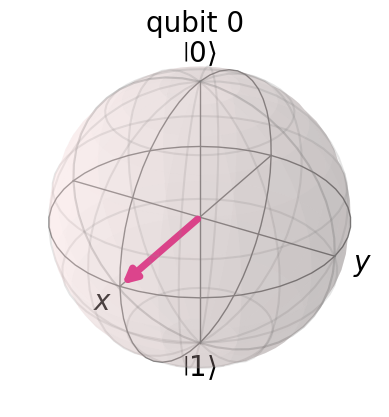

In [110]:
# ACTION OF THE H GATE ON THE BLOCH SPHERE

qc = QuantumCircuit(N)
qc.h(0)
state = Statevector(qc)
plot_bloch_multivector(state)

**Pauli Gates .** Some important matrices in linear algebra are the [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices) which are the unitary involutory matrices given by $$\sigma_x:=\begin{pmatrix}0&1\\ 1&0\end{pmatrix} \ \ \ , \ \ \ \sigma_y:=\begin{pmatrix}0&i\\ -i&0\end{pmatrix} \ \ \ , \ \ \ \sigma_z:=\begin{pmatrix}1&0\\ 0&-1\end{pmatrix} \ .$$
This matrices are important quantum gates and have theyr own symbol, $X$, $Y$ and $Z$, repsectively.

In [111]:
# PAULI X GATE
# Remark . To have the other pauli gates change qc.x into qc.y or qc.z

qc = QuantumCircuit(N)
qc.x(0)
qc.draw()

┌───┐
q: ┤ X ├
   └───┘

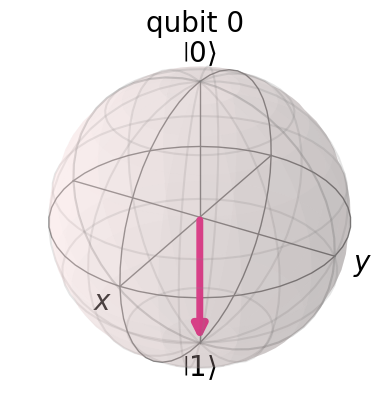

In [112]:
# ACTION OF THE X GATE ON THE BLOCH SPHERE

qc = QuantumCircuit(N)
qc.x(0)
state = Statevector(qc)
plot_bloch_multivector(state)

As we can see the $X$ gate acs like a $NOT$ gate, this is not suprising since the pauli gate $X$ has the same matrix form of a $NOT$ gate (the matrix exchanges the entries of a bidimensional vector).

**Phase appending P Gates .** The $P$ gate (phase gate) is a parametrised circuit given in matrix form by $$P_\theta:=\begin{pmatrix}1&0\\ 0 & e^{i\theta}\end{pmatrix}$$ with $\theta \in \mathbb{R}$. Notice that the $P$ corresponds to the $Z$ gate when $\theta=\pi$.

In [113]:
# PHASE P GATE

qc = QuantumCircuit(N)
qc.p(math.pi,0)
qc.draw()

┌──────┐
q: ┤ P(π) ├
   └──────┘

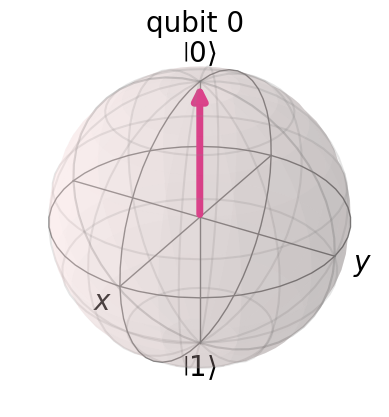

In [114]:
# ACTION OF THE P GATE ON THE BLOCH SPHERE

qc = QuantumCircuit(N)
qc.p(math.pi, 0)
state = Statevector(qc)
plot_bloch_multivector(state)

It is not surprising that this gate didn't produce any particular effect on the Bloch sphere, indeed the $P$ gate perform a rotation on the $z$ axes. To see its action we can for example work with $|+\rangle$ instead of $|0\rangle$.

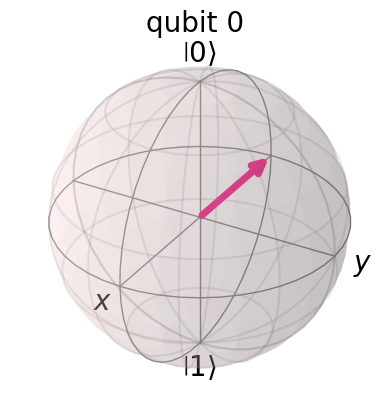

In [115]:
# ACTION OF THE P GATE ON THE BLOCH SPHERE CONTINUED


initial_state = [1/math.sqrt(2), -1/math.sqrt(2)]
qc = QuantumCircuit(N)
qc.initialize(initial_state, 0)
qc.p(math.pi, 0)
plot_bloch_multivector(initial_state)

**The General single-qubit $U$ Gate .** Every quantum gate can be represented by a single parametrized matrix of the form $$U(\theta,\phi,\lambda)=\begin{pmatrix}\cos\frac{\theta}{2}&-e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i(\phi+\lambda)}\cos\frac{\theta}{2}\end{pmatrix}$$

The proof that any signle qubit gate can be obtained by combining $U$ gates follows from the rotation gates theorem. 

**Rotation Gates .** Rotation gates ar obtained from a $U$ gate in the following way: $R_x(\theta)=U(\theta,-\frac{\pi}{2},\frac{\pi}{2})$, $R_y(\theta)=U(\theta,0,0)$ and $R_z(\theta)=P(\theta)$.

## Exercises

**Exercise 1 .** Write a circuit that performs basis encoding.

**Exercise 2 .** Here we will explore the *Angle Encoding*. Suppose to have a classical array of data $D$, it is possible to use rotation gates to encode a data element $D_i$ into a quantum state as follows: $$D\to |D\rangle:=\bigotimes_{i=1}^n(\cos(D_i)|0\rangle+\sin(D_i)|1\rangle) $$ where $n$ is the number of qubits. 

* Use angle encoding to encode $D=(\pi,\pi,\pi)^T$;
* Build a circuit to perform angle encoding in a general setting. 

**Exercise 3 .** The method `measure.all()` measures the states with respect to the computational bases, that is the bases obtained using the basis encoding. Calculate the probability of measuring $|+\rangle$ or $|-\rangle$, or $|0\rangle$ using $\{|+\rangle, |-\rangle\}$ as basis. 

**Exercise 4 .** Find the eigenstates of the Pauli gates.

**Exercise 5 .** The $S$ gate is a $P$ gate with $\theta=\frac{\pi}{2}$. The $T$ gate is a $P$ gate with $\theta=\frac{\pi}{4}$. Write a circuit that performs the $S$ gate followed by a $T$ gate and represent the action of this composite operation on the Bloch sphere. 

**Exercise 6 .** What is the the result of the following commands in Qiskit?

In [116]:
qc.sdg(0)
qc.tdg(0)

**Exercise 7 .** Write a circuit that performs a rotation gates.

*Hint .* Use the commands `qc.u()` or `qc.rx()` and `qc.ry()`.

**Exercise 8 .** An oracle is any "process" able to compute a function $f:\{0,1\}^n\to \{0,1\}^m$ 
as a single operation. Since $f$ is not necessarly invertible, how can we define
an oracle to perform reversible computation in a quantum setting? For example how can we define an oracle to find out if $f:\{0,1\}\to \{0,1\}$ is constant?

**Exercise 9 .** Consider the pure states $|0\rangle$ and $|1\rangle$. Consider the coherent superposition of these states $|\psi\rangle =\alpha|0\rangle +\beta|1\rangle$ with $|\alpha|^2+|\beta|^2 =1$. Find the expression of the pure state $|\psi\rangle$ as an orthogonal projector.

**Exercise 10 .** There are many interesting visualizations apart from the representation of a circuit and its gates with the command `qc.draw()` and apart from the Bloch sphere. Check [this tutorial](https://qiskit.org/documentation/tutorials/circuits/2_plotting_data_in_qiskit.html) and then:

* Plot the histogram with the results of two consecutive runs of a circuit with an $H$ gate;
* Use the command `plot_state_city()` to represent the result of a circuit with an $H$ gate followed by an $X$ gate.

## Notes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Fortunately, a [theorem of Ehrenfest](https://en.wikipedia.org/wiki/Ehrenfest_theorem) says that the expected values of such variables satisfy classical laws, e.g. the Newton's law $\frac{d\langle p\rangle }{dt}=\langle -\frac{\partial V}{\partial x}\rangle$. In general one just need to remember a "canonical transformation": if $Q=Q(x,p)$ is any dynamic variable, then to get the expectation $\langle Q\rangle$ it suffice to assign to each occurence of $p$ the operator $\frac{\hbar}{i}(\frac{\partial}{\partial x})$, insert the operator between the wave functions $\psi$ and $\psi^*$, then integrate, that is $$\langle Q(x,p)\rangle=\int \psi^*Q(x,\frac{\hbar}{i}\frac{\partial}{\partial x}) \psi dx \ .$$ This trick works beacuse $\psi$ is "regular" enough (e.g. wave functions are in $L^2$, they wanish at infinity, etc...) and integration by parts allows to calculate directly the expecation neglecting the boundary terms.

<a name="cite_note-2"></a>2. [^](#cite_ref-2) By separation of variables we can assume $\psi(x,t)=\phi(x)f(t)$ so  $\partial_t\phi=\phi\dot{f}$ and $\partial_{xx}\phi=\ddot{\phi}f$ and the Schrödinger equation becomes (after dividing by $\phi f$): $$i\hbar \frac{1}{f}\frac{df}{dt}=-\frac{\hbar^2}{2m}\frac{1}{\phi}\frac{d^2\phi}{dx^2}+V \ .$$ The term on the left is function only of $t$, the term on the right is function only of $x$ so there must by a separating constant $E$ such that $i\hbar\frac{1}{f}\frac{df}{dt}=E$ and $-\frac{\hbar^2}{2m\phi}\frac{d^2\phi}{dx^2}+V=E$. The first equation yields $f(t)=e^{\frac{iEt}{\hbar}}$ and the second equation can be solved once the potential $V$ is known. In any case to build $\psi$ one can check every possible (discrete) value of the "energy" $E$ and recover a "fourier" expansion of the form $$\psi(x,t)=\sum_n c_n\phi_n(x)e^{\frac{iE_nt}{\hbar}} $$ where $\phi_n$ correspond to an "energy" value $E_n$. Indeed in can be seen that the values $E_1,E_2,\dots$ are the well defined values of the total energy $H(x,p)=\frac{p^2}{2m}+V(x)$ with $p=m\frac{dx}{dt}$ the linear momentum. More precisely the canonical substitution $p\to \frac{\hbar}{i}(\frac{\partial}{\partial x})$ gives $$H\to \hat{H}:=-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} +V(x)$$ and the Schrödinger equation becomes $\hat{H}\phi=E\phi$ and the expected value of the energy is precisely $$\langle H\rangle=\int \phi^*\hat{H}\phi dx=E\int |\phi|^2dx =E\ . $$ Moreover its variance is zero, so every measure of the total energy gives with certainty the value of the separating constant. When dealing with a time-dependent hamiltonian the "unitary evolution" must be adapted incorporating the one-parameter family of self-adjoint operators $\{H(t)\}_{t\in \mathbb{R}}$ and the Schrödinger equation assumes the form $i\hbar\frac{d}{dt}|\phi_t\rangle = H(t) |\phi_t\rangle$ which is crucial for the Adiabatic Quantum Computing (cfr. Notebook.....)

<a name="cite_note-3"></a>3. [^](#cite_ref-3) Bit, as the contraction of "binary digit", i.e. an element $b\in \{0,1\}$, can also be viewed as the unit measure of the information-theoretic *entropy*. By Shannon's [fundamental theorem of the noisless channel](https://en.wikipedia.org/wiki/Shannon%27s_source_coding_theorem) if a source has entropy $H$ and transmits in a channel with capacity $C$, then it is possible to encode the output of the source in such a way as to transmit at the average rate of $\frac{C}{H}-\epsilon$ sybols per seconds over the channel, where $\epsilon$ is arbitrarily small. That is why the entropy of a message measured in bits tell us how many binary digits $b\in \{0,1\}$ are required to transimt a source message. In this sense the identification between binary digits (elements taken from $\{0,1\}$) and bits (unit measure of information-theoretic entropy) is subtle. But there is more! Since there is a natural correspondence between the information-theoretic entropy $H$ and the thermodinamic entropy function $S$ a bit can be viewed also in therms of the energy $E$ of a thermodynamical system: the decrease of entropy $S$ while halving the volume of an ideal, one-molecule, classical gas at a given temperature $T$ is given by $k\log_2\frac{1}{2}=-0.693 k$ and the corresponding change in free energy $E-ST$ is $0,693 kT$ which is the minimum possible energy required to transmit a $bit$ (i.e. $0$ if the molecule of the gas is not present after the halving process, $1$ otherwise). See...  

<a name="cite_note-4"></a>4. [^](#cite_ref-4) When dealing with information in a quantum setting it is not possible to rely on "classical" information-theoretic concepts like the entropy introduced by Shannon, but one needs to extend the "classical" definitions in a new setting. For example Shannon's entropy $H$ in the "classical" setting is given by $H(x)=\mathbb{E}(-log_2(p_X(x)))$ where $p_X$ is the probability density of a random variable of interest $X$. The previous definition needs to be adapted in a "quantum" setting by considering the von Newman entropy, which measures (up to a multiplicative constant) how many quibits are needed to encode a message without loss of information, that is: $\textrm{Tr}\eta(\varrho)$ where $\eta(t)=-t\log(t)$ and $\varrho$ is an arbitrary density matrix. See...

<a name="cite_note-5"></a>5. [^](#cite_ref-5) There are many ways to realize a "logical" qubit into hardware. Some common techniques involve: small electronic circuits made with superconducting materials cooled at very low temperatures and controlled by microwaves' pulses, photonic systems at room temperature controlled by light pulses, or trapped ions systems cooled at very low temperatures and controlled by laser pulses. Each technology has its benefits and drawbacks, see.... 

<a name="cite_note-6"></a>6. [^](#cite_ref-6) See this post on [this post on  quantumcomputing stackexchange](https://quantumcomputing.stackexchange.com/questions/5199/general-parametrisation-of-an-arbitrary-2-times-2-unitary-matrix)

<a name="cite_note-7"></a>7. [^](#cite_ref-7) Those vectors (kets) are the the eigenstates of the pauli matrix $\sigma_z$.

<a name="cite_note-8"></a>8. [^](#cite_ref-8) To see this, we have that $|\psi\rangle=\frac{\hat{x}-\hat{y}}{\sqrt{2}}$ is an eigenvector of $H$ (its eigenvalues are $\pm 1$ and $H|\psi\rangle=(-1)|\psi\rangle$ shows that that axes is fixed by $H$ and $H|\psi\rangle$ is equal to $|\psi\rangle$ up to a global phase). Moreover $H$ is an involution (i.e. $H^2$ is the identity) with both eigenvectors fixed up to a global phase, so it's action on the Bloch sphere must be equivalent to a rotation by $\pi$ (recall that the Bloch sphere is a complex projective line and not an euclidean $2D-$sphere where $det(H)=-1$ would have meant a reflection). Another "brute force" way to see this is to consider a general rotation of the $y$ axes given in matrix for as $$R_y(\theta)=\begin{pmatrix}\cos\frac{\theta}{2} &-\sin\frac{\theta}{2}\\ \sin\frac{\theta}{2} &\cos\frac{\theta}{2}\end{pmatrix}$$ setting $\theta=\frac{\pi}{2}$ we have $$\frac{1}{\sqrt{2}}\begin{pmatrix}1&-1\\1&1\end{pmatrix}$$ which is "almost" the $H$ gate, up to a phase shift if applyied to $|1\rangle$. In this case we can search for the matrix $X$ shuch that $$XR_y(\frac{\pi}{2})=H $$ and its easy too see that $$X=\begin{pmatrix}0&1\\1&0\end{pmatrix}$$ will yield the result. Writing $X$ as a rotation of the Bloch sphere we have $$X\to R_x(\theta)$$ with $\theta=\pi$ we have $$R_x(\pi)=\begin{pmatrix}\cos\frac{\pi}{2}&-i\sin\frac{\pi}{2}\\ -i\sin\frac{\pi}{2} &\cos\frac{\pi}{2}\end{pmatrix}=\begin{pmatrix}0&-i\\-i&0\end{pmatrix}=-iX$$ so $R_x(\pi)R_y(\frac{\pi}{2})=-iH$, that is the Hadamard gate up to global phase.

<a name="cite_note-9"></a>9. [^](#cite_ref-9) The action of $U_f$ on $|+\rangle\otimes|-\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\otimes\frac{|0\rangle-|1\rangle}{\sqrt{2}}$ is $(x,y\oplus f(x))$ where $x=\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $y=\frac{|0\rangle-|1\rangle}{\sqrt{2}}$. If $f(x)=0$ the second qubit is simply $y$ (dropping for now $\frac{1}{\sqrt{2}}$ without loss of generality) so when $f(x)=0$ the action of $U_f$ is $(x,y)\to (x,y)$, that is $|x\rangle(|0\rangle-|1\rangle)\to |x\rangle(|0\rangle-|1\rangle)$. Likewise if $f(x)=1$ we have $(x,y)\to(x,y\oplus 1)$ and $|x\rangle(|0\rangle-|1\rangle)\to |x\rangle(|1\rangle-|0\rangle)$. By examining the outputs we can merge the previous two relations into $(-1)^{f(x)}|x\rangle(|0\rangle-|1\rangle)$. replacing $|x\rangle$ with $|0\rangle+|1\rangle$ we get $(-1)^{f(0)}|0\rangle+(-1)^{f(1)}|1\rangle$. So the result of the oracle $U_f$ is $$\frac{|0\rangle+|1\rangle}{\sqrt{2}}\otimes\frac{|0\rangle-|1\rangle}{\sqrt{2}}\to\frac{(-1)^{f(0)}|0\rangle+(-1)^{f(1)}|1\rangle}{\sqrt{2}} \otimes \frac{|0\rangle-|1\rangle}{\sqrt{2}}\ .$$ At this poin we can go through all the possible combinations and compute the superposition of the first qubit for each scenario. For example if $f(0)=0$ and $f(1)=1$ or $f(1)=0$ and $f(0)=1$, we have that the first qubit is $\pm\frac{|0\rangle +|1\rangle}{\sqrt{2}}$ which differ only for the sign, i.e. the states are equivalent since they differ only by a phase shift of $\pi$.